# 📊 Objective 3: Mixed-Effects Regression & Propensity Score Matching
## MCM Problem C 2026

**Goal:** Quantify the causal impact of pro dancers on celebrity performance while controlling for celebrity characteristics.

### Key Questions:
1. How much variance in performance is explained by the pro dancer?
2. What celebrity characteristics predict success (controlling for pro)?
3. Are effects different for judge scores vs. fan votes?

### Methodology:
- **Mixed-Effects Models:** Celebrity fixed effects + Pro dancer random effects
- **Propensity Score Matching:** Isolate pro dancer effect
- **Dual Pathway Analysis:** Separate models for judge scores vs. fan votes

---

## 1. Setup & Data Loading

In [25]:
# Core libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import statsmodels.api as sm
import statsmodels.formula.api as smf
from scipy import stats
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import RandomForestRegressor
import warnings
warnings.filterwarnings('ignore')

# Display settings
pd.set_option('display.max_columns', 60)
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette('husl')

DATA_PATH = Path('../../data')
OUTPUT_PATH = DATA_PATH / 'obj3'

print("✓ Libraries loaded")

✓ Libraries loaded


In [2]:
# Load feature dataset from previous notebook
features_df = pd.read_csv(OUTPUT_PATH / 'celebrity_features.csv')
pro_stats_df = pd.read_csv(OUTPUT_PATH / 'pro_dancer_stats.csv')

# Load fan vote estimates from Objective 1 (for dual-pathway analysis)
fan_votes_df = pd.read_csv(DATA_PATH / 'obj1' / 'fan_vote_estimates.csv')

print(f"Features dataset: {features_df.shape}")
print(f"Fan vote estimates: {fan_votes_df.shape}")
print(f"\nColumns: {list(features_df.columns)}")

Features dataset: (421, 21)
Fan vote estimates: (2067, 11)

Columns: ['celebrity_name', 'ballroom_partner', 'season', 'placement', 'celebrity_age_during_season', 'age_bracket', 'celebrity_industry', 'industry_cluster', 'celebrity_homestate', 'region', 'wiki_pageviews', 'star_power_index', 'pro_experience', 'win_rate', 'top3_rate', 'avg_placement', 'first_week_score', 'improvement_rate', 'score_volatility', 'peak_score', 'weeks_competed']


In [3]:
# Check missing values
print("Missing values per column:")
print(features_df.isnull().sum().sort_values(ascending=False).head(10))

Missing values per column:
wiki_pageviews         237
celebrity_homestate     56
peak_score              17
score_volatility        17
improvement_rate        17
star_power_index         7
first_week_score         0
avg_placement            0
top3_rate                0
win_rate                 0
dtype: int64


In [4]:
# Prepare analysis dataset (drop rows with missing key variables)
analysis_cols = ['celebrity_name', 'ballroom_partner', 'season', 'placement',
                 'celebrity_age_during_season', 'industry_cluster', 'region',
                 'star_power_index', 'pro_experience', 'win_rate',
                 'first_week_score', 'improvement_rate', 'weeks_competed']

df = features_df[analysis_cols].dropna(subset=['improvement_rate', 'star_power_index']).copy()

# Encode categorical variables
le_industry = LabelEncoder()
le_region = LabelEncoder()
le_pro = LabelEncoder()

df['industry_code'] = le_industry.fit_transform(df['industry_cluster'])
df['region_code'] = le_region.fit_transform(df['region'])
df['pro_code'] = le_pro.fit_transform(df['ballroom_partner'])

print(f"Analysis dataset: {df.shape[0]} contestants")
print(f"Unique pro dancers: {df['ballroom_partner'].nunique()}")

Analysis dataset: 397 contestants
Unique pro dancers: 54


---

## 2. Variance Decomposition: How Much Does the Pro Matter?

We use a mixed-effects model to partition variance:

$$\text{Placement}_i = \beta_0 + \beta X_i + u_{pro(i)} + \epsilon_i$$

where $u_{pro(i)} \sim N(0, \sigma^2_{pro})$ is the random effect for the pro dancer.

In [5]:
# Mixed-effects model: Placement ~ Celebrity Features + (1 | Pro Dancer)
# Using statsmodels MixedLM

# Formula: placement as dependent, celebrity features as fixed, pro as random
mixed_model = smf.mixedlm(
    "placement ~ celebrity_age_during_season + C(industry_cluster) + C(region) + star_power_index",
    data=df,
    groups=df['ballroom_partner']
)

mixed_result = mixed_model.fit(method='powell')
print("\n" + "="*70)
print("MIXED-EFFECTS MODEL: Placement ~ Celebrity Features + (1|Pro)")
print("="*70)
print(mixed_result.summary())


MIXED-EFFECTS MODEL: Placement ~ Celebrity Features + (1|Pro)
                 Mixed Linear Model Regression Results
Model:                  MixedLM      Dependent Variable:      placement 
No. Observations:       397          Method:                  REML      
No. Groups:             54           Scale:                   9.8458    
Min. group size:        1            Log-Likelihood:          -1023.4957
Max. group size:        25           Converged:               Yes       
Mean group size:        7.4                                             
------------------------------------------------------------------------
                              Coef.  Std.Err.   z    P>|z| [0.025 0.975]
------------------------------------------------------------------------
Intercept                      1.937    0.692  2.800 0.005  0.581  3.293
C(industry_cluster)[T.Media]   2.437    0.801  3.041 0.002  0.867  4.008
C(industry_cluster)[T.Other]   1.049    0.672  1.562 0.118 -0.267  2.365
C(indu

In [6]:
# Calculate Intraclass Correlation Coefficient (ICC)
# ICC = var(pro) / (var(pro) + var(residual))
# This tells us what % of variance is explained by the pro dancer

var_pro = mixed_result.cov_re.iloc[0, 0]  # Random effect variance
var_resid = mixed_result.scale  # Residual variance

icc = var_pro / (var_pro + var_resid)

print(f"\n📊 VARIANCE DECOMPOSITION")
print("="*50)
print(f"Pro dancer variance (σ²_pro): {var_pro:.3f}")
print(f"Residual variance (σ²_resid): {var_resid:.3f}")
print(f"\n🎯 Intraclass Correlation (ICC): {icc:.1%}")
print(f"   → {icc:.1%} of placement variance is due to the pro dancer")
print(f"   → {(1-icc):.1%} is due to celebrity characteristics & random factors")


📊 VARIANCE DECOMPOSITION
Pro dancer variance (σ²_pro): 0.554
Residual variance (σ²_resid): 9.846

🎯 Intraclass Correlation (ICC): 5.3%
   → 5.3% of placement variance is due to the pro dancer
   → 94.7% is due to celebrity characteristics & random factors


In [7]:
# Extract pro dancer random effects (BLUPs)
pro_effects = pd.DataFrame({
    'pro_dancer': mixed_result.random_effects.keys(),
    'effect': [v['Group'] for v in mixed_result.random_effects.values()]
})

# Negative effect = better (lower) placement
pro_effects = pro_effects.sort_values('effect')

print("\n🏆 PRO DANCER EFFECTS (Negative = Better Performance):")
print("="*60)
print("\nTOP 10 (Most positive impact):")
print(pro_effects.head(10).to_string(index=False))
print("\nBOTTOM 10 (Least positive impact):")
print(pro_effects.tail(10).to_string(index=False))


🏆 PRO DANCER EFFECTS (Negative = Better Performance):

TOP 10 (Most positive impact):
           pro_dancer    effect
          Derek Hough -1.520294
          Kym Johnson -0.600470
         Cheryl Burke -0.563126
      Edyta Sliwinska -0.449411
         Corky Ballas -0.387928
    Daniella Karagach -0.363374
Valentin Chmerkovskiy -0.332484
       Julianne Hough -0.314385
       Lindsay Arnold -0.293838
  Charlotte Jorgensen -0.292961

BOTTOM 10 (Least positive impact):
       pro_dancer   effect
    Brian Fortuna 0.195181
    Tony Dovolani 0.235061
  Karina Smirnoff 0.257761
 Anna Trebunskaya 0.381733
Chelsie Hightower 0.435073
      Keo Motsepe 0.519914
    Britt Stewart 0.562908
   Gleb Savchenko 0.636475
Brandon Armstrong 0.773429
    Pasha Pashkov 0.814429


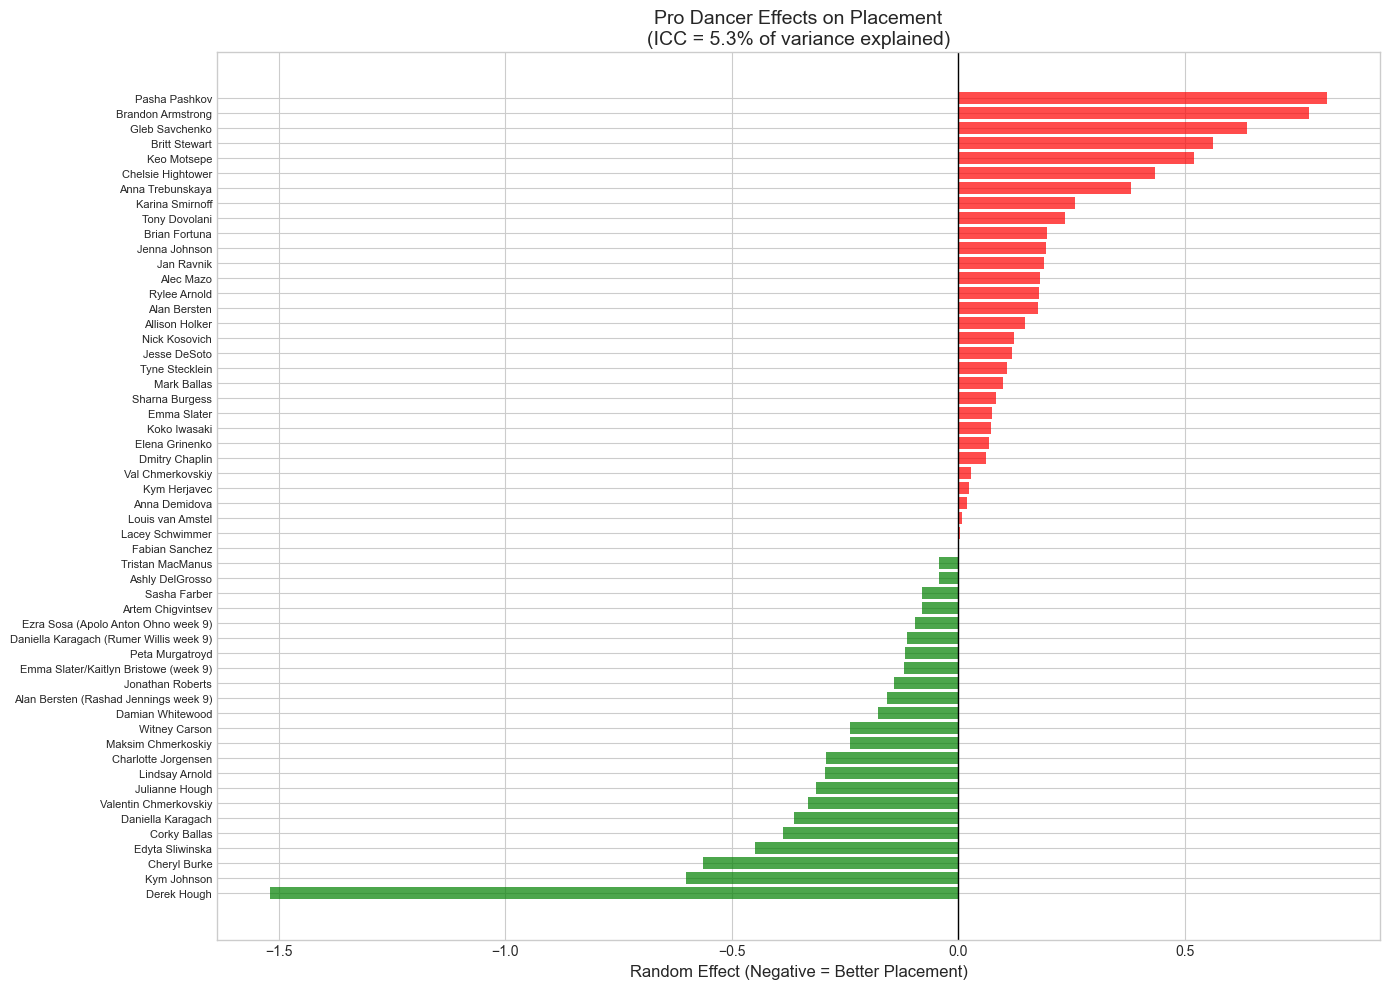

In [8]:
# Visualize pro dancer effects
fig, ax = plt.subplots(figsize=(14, 10))

# Sort and plot
pro_effects_sorted = pro_effects.sort_values('effect')
colors = ['green' if e < 0 else 'red' for e in pro_effects_sorted['effect']]

ax.barh(range(len(pro_effects_sorted)), pro_effects_sorted['effect'], color=colors, alpha=0.7)
ax.set_yticks(range(len(pro_effects_sorted)))
ax.set_yticklabels(pro_effects_sorted['pro_dancer'], fontsize=8)
ax.axvline(0, color='black', linestyle='-', linewidth=1)
ax.set_xlabel('Random Effect (Negative = Better Placement)', fontsize=12)
ax.set_title(f'Pro Dancer Effects on Placement\n(ICC = {icc:.1%} of variance explained)', fontsize=14)

plt.tight_layout()
plt.savefig(OUTPUT_PATH / 'pro_dancer_effects.png', dpi=150, bbox_inches='tight')
plt.show()

---

## 3. Celebrity Characteristic Analysis

Which celebrity features predict better performance, controlling for pro dancer?

In [9]:
# Extract fixed effects from the mixed model
fixed_effects = pd.DataFrame({
    'variable': mixed_result.fe_params.index,
    'coefficient': mixed_result.fe_params.values,
    'std_error': mixed_result.bse_fe.values,
    'p_value': mixed_result.pvalues[:len(mixed_result.fe_params)].values
})

fixed_effects['significant'] = fixed_effects['p_value'] < 0.05

print("\n📊 FIXED EFFECTS (Celebrity Characteristics):")
print("="*70)
print(fixed_effects.to_string(index=False))


📊 FIXED EFFECTS (Celebrity Characteristics):
                     variable  coefficient  std_error      p_value  significant
                    Intercept     1.937168   0.691864 5.111444e-03         True
 C(industry_cluster)[T.Media]     2.437261   0.801397 2.355859e-03         True
 C(industry_cluster)[T.Other]     1.049099   0.671583 1.182578e-01        False
C(industry_cluster)[T.Sports]     0.052285   0.405933 8.975141e-01        False
         C(region)[T.Midwest]     0.115165   0.622399 8.532024e-01        False
       C(region)[T.Northeast]    -0.288796   0.572862 6.141711e-01        False
       C(region)[T.Southeast]    -0.427929   0.561497 4.459874e-01        False
       C(region)[T.Southwest]    -0.005544   0.741341 9.940336e-01        False
        C(region)[T.US-Other]     0.376222   1.503626 8.024250e-01        False
            C(region)[T.West]     0.398433   0.568167 4.831406e-01        False
  celebrity_age_during_season     0.115113   0.012557 4.865041e-20        

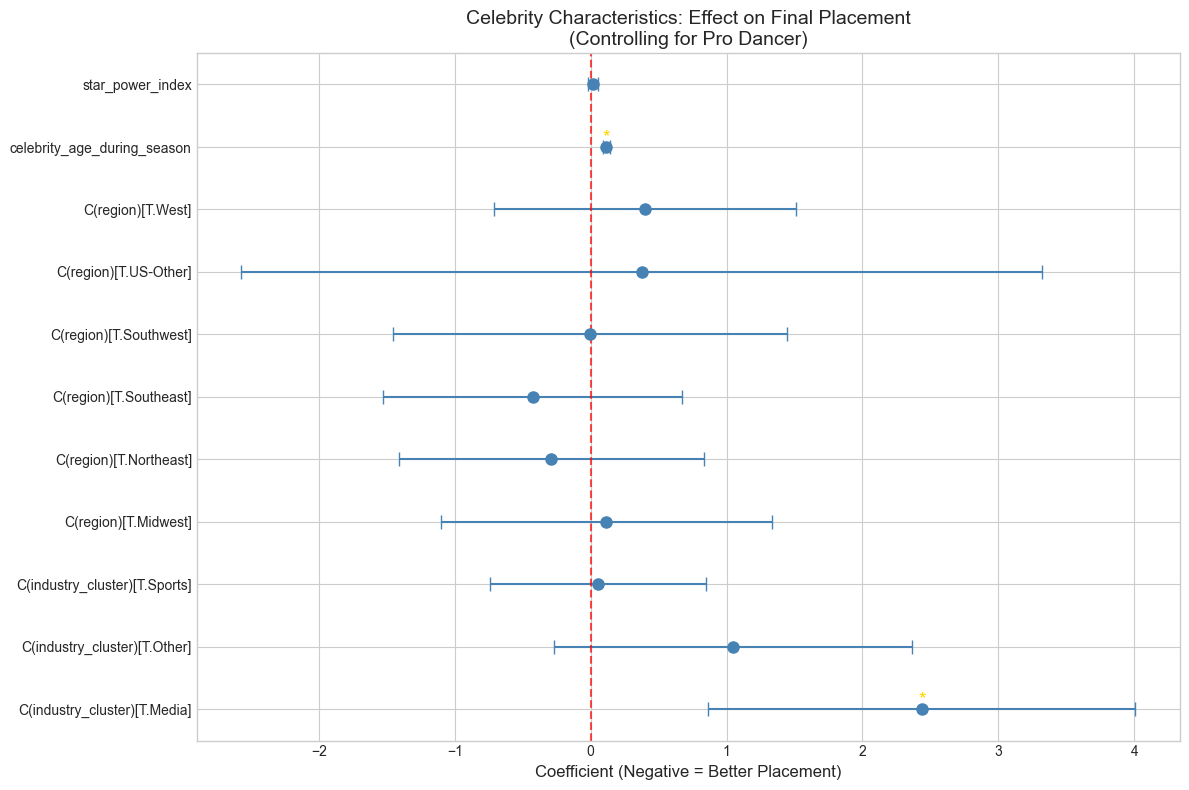

In [10]:
# Visualize fixed effects (coefficient plot)
fig, ax = plt.subplots(figsize=(12, 8))

# Filter out intercept for visualization
fe_plot = fixed_effects[fixed_effects['variable'] != 'Intercept'].copy()

# Create coefficient plot with confidence intervals
y_pos = range(len(fe_plot))
colors = ['green' if c < 0 else 'red' for c in fe_plot['coefficient']]

ax.errorbar(fe_plot['coefficient'], y_pos, 
            xerr=1.96*fe_plot['std_error'], fmt='o', 
            capsize=5, color='steelblue', markersize=8)

ax.axvline(0, color='red', linestyle='--', alpha=0.7)
ax.set_yticks(y_pos)
ax.set_yticklabels(fe_plot['variable'], fontsize=10)
ax.set_xlabel('Coefficient (Negative = Better Placement)', fontsize=12)
ax.set_title('Celebrity Characteristics: Effect on Final Placement\n(Controlling for Pro Dancer)', fontsize=14)

# Add significance markers
for i, (idx, row) in enumerate(fe_plot.iterrows()):
    if row['significant']:
        ax.annotate('*', xy=(row['coefficient'], i), fontsize=14, color='gold',
                   ha='center', va='bottom')

plt.tight_layout()
plt.savefig(OUTPUT_PATH / 'celebrity_effects.png', dpi=150, bbox_inches='tight')
plt.show()

---

## 4. Propensity Score Matching: Isolating Pro Dancer Effect

To better isolate the pro dancer effect, we use propensity score matching:
1. Model probability of being assigned to a "top" pro (high win rate)
2. Match celebrities with similar propensity scores
3. Compare outcomes between matched pairs

In [11]:
# Define "top pro" as those with win rate > median (among those with 3+ seasons)
pro_with_experience = pro_stats_df[pro_stats_df['seasons_count'] >= 3].copy()
win_rate_median = pro_with_experience['win_rate'].median()

print(f"Median win rate (experienced pros): {win_rate_median:.1%}")

# Create binary treatment: assigned to "top pro" (above median win rate)
df['top_pro'] = (df['win_rate'] > win_rate_median).astype(int)

print(f"\nTreatment distribution:")
print(f"  Top Pro (win rate > {win_rate_median:.1%}): {df['top_pro'].sum()} celebrities")
print(f"  Regular Pro: {(1-df['top_pro']).sum()} celebrities")

Median win rate (experienced pros): 5.2%

Treatment distribution:
  Top Pro (win rate > 5.2%): 237 celebrities
  Regular Pro: 160 celebrities


In [12]:
# Propensity score model: P(Top Pro | Celebrity Characteristics)
from sklearn.linear_model import LogisticRegression

# Features for propensity model
propensity_features = ['celebrity_age_during_season', 'star_power_index', 
                       'industry_code', 'region_code', 'season']

X_prop = df[propensity_features].fillna(0)
y_prop = df['top_pro']

# Fit logistic regression
propensity_model = LogisticRegression(max_iter=1000, random_state=42)
propensity_model.fit(X_prop, y_prop)

# Get propensity scores
df['propensity_score'] = propensity_model.predict_proba(X_prop)[:, 1]

print(f"Propensity score distribution:")
print(df.groupby('top_pro')['propensity_score'].describe())

Propensity score distribution:
         count      mean       std       min       25%       50%       75%  \
top_pro                                                                      
0        160.0  0.563256  0.119025  0.246916  0.485364  0.571123  0.653988   
1        237.0  0.619731  0.108705  0.309693  0.551852  0.627727  0.703648   

              max  
top_pro            
0        0.832341  
1        0.823323  


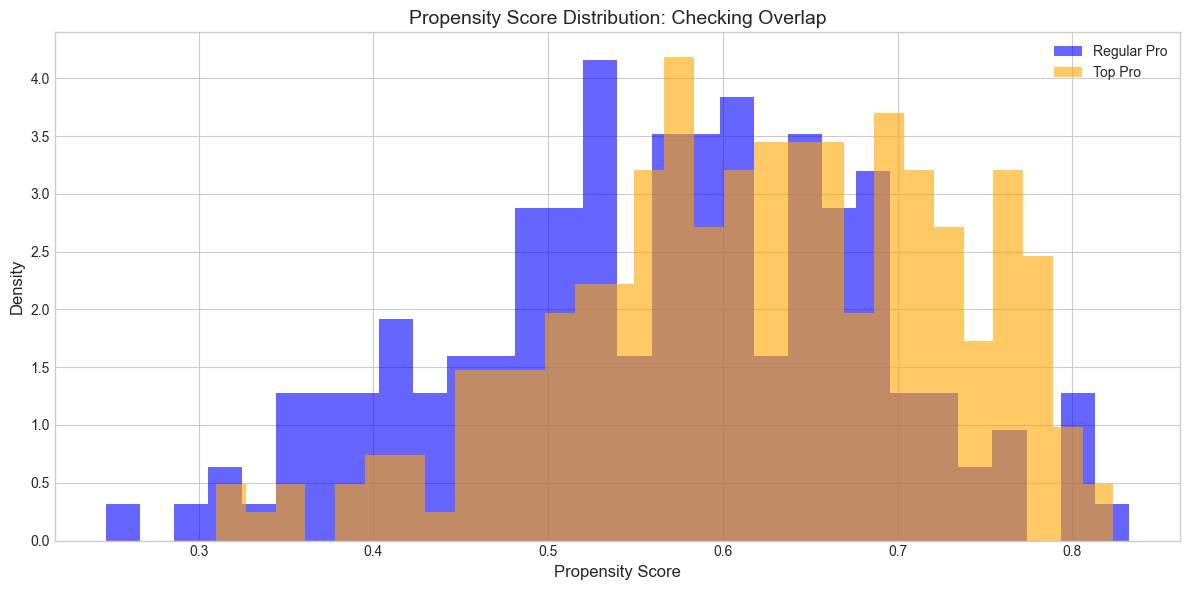

In [13]:
# Visualize propensity score overlap
fig, ax = plt.subplots(figsize=(12, 6))

ax.hist(df[df['top_pro']==0]['propensity_score'], bins=30, alpha=0.6, 
        label='Regular Pro', color='blue', density=True)
ax.hist(df[df['top_pro']==1]['propensity_score'], bins=30, alpha=0.6,
        label='Top Pro', color='orange', density=True)

ax.set_xlabel('Propensity Score', fontsize=12)
ax.set_ylabel('Density', fontsize=12)
ax.set_title('Propensity Score Distribution: Checking Overlap', fontsize=14)
ax.legend()

plt.tight_layout()
plt.savefig(OUTPUT_PATH / 'propensity_overlap.png', dpi=150, bbox_inches='tight')
plt.show()

In [14]:
# Nearest-neighbor matching on propensity score
from scipy.spatial import distance

def match_propensity(df, caliper=0.1):
    """
    Match each treated (top_pro=1) to nearest control (top_pro=0)
    within caliper distance.
    """
    treated = df[df['top_pro'] == 1].copy()
    control = df[df['top_pro'] == 0].copy()
    
    matches = []
    used_controls = set()
    
    for idx, row in treated.iterrows():
        ps = row['propensity_score']
        
        # Find controls within caliper
        available = control[~control.index.isin(used_controls)]
        distances = np.abs(available['propensity_score'] - ps)
        
        if len(distances) > 0 and distances.min() <= caliper:
            match_idx = distances.idxmin()
            used_controls.add(match_idx)
            
            matches.append({
                'treated_idx': idx,
                'control_idx': match_idx,
                'treated_ps': ps,
                'control_ps': available.loc[match_idx, 'propensity_score'],
                'treated_placement': row['placement'],
                'control_placement': available.loc[match_idx, 'placement'],
                'treated_improvement': row['improvement_rate'],
                'control_improvement': available.loc[match_idx, 'improvement_rate']
            })
    
    return pd.DataFrame(matches)

matched_df = match_propensity(df, caliper=0.15)
print(f"\nMatched {len(matched_df)} pairs (caliper=0.15)")


Matched 156 pairs (caliper=0.15)


In [15]:
# Calculate Average Treatment Effect (ATE) from matched pairs
ate_placement = matched_df['treated_placement'].mean() - matched_df['control_placement'].mean()
ate_improvement = matched_df['treated_improvement'].mean() - matched_df['control_improvement'].mean()

# Standard errors via bootstrap
n_boot = 1000
boot_ate_placement = []
boot_ate_improvement = []

for _ in range(n_boot):
    sample = matched_df.sample(n=len(matched_df), replace=True)
    boot_ate_placement.append(sample['treated_placement'].mean() - sample['control_placement'].mean())
    boot_ate_improvement.append(sample['treated_improvement'].mean() - sample['control_improvement'].mean())

se_placement = np.std(boot_ate_placement)
se_improvement = np.std(boot_ate_improvement)

print("="*70)
print("AVERAGE TREATMENT EFFECT (Top Pro vs Regular Pro)")
print("="*70)
print(f"\n📊 PLACEMENT EFFECT:")
print(f"   ATE = {ate_placement:.2f} places (SE = {se_placement:.2f})")
print(f"   95% CI: [{ate_placement - 1.96*se_placement:.2f}, {ate_placement + 1.96*se_placement:.2f}]")
if ate_placement < 0:
    print(f"   → Top pro improves placement by {abs(ate_placement):.1f} places on average")
else:
    print(f"   → Top pro worsens placement by {ate_placement:.1f} places on average")

print(f"\n📊 IMPROVEMENT RATE EFFECT:")
print(f"   ATE = {ate_improvement:.3f} pts/week (SE = {se_improvement:.3f})")
print(f"   95% CI: [{ate_improvement - 1.96*se_improvement:.3f}, {ate_improvement + 1.96*se_improvement:.3f}]")

AVERAGE TREATMENT EFFECT (Top Pro vs Regular Pro)

📊 PLACEMENT EFFECT:
   ATE = -1.70 places (SE = 0.36)
   95% CI: [-2.41, -0.99]
   → Top pro improves placement by 1.7 places on average

📊 IMPROVEMENT RATE EFFECT:
   ATE = 0.005 pts/week (SE = 0.048)
   95% CI: [-0.090, 0.099]


---

## 5. Dual-Pathway Analysis: Judge Scores vs. Fan Votes

Do celebrity characteristics affect judge scores and fan votes differently?

In [16]:
# Merge fan vote data with features
merged_df = fan_votes_df.merge(
    features_df[['celebrity_name', 'season', 'industry_cluster', 'region', 
                 'star_power_index', 'celebrity_age_during_season', 
                 'ballroom_partner', 'win_rate']],
    on=['celebrity_name', 'season'],
    how='left'
)

# Filter to rows with complete data
merged_df = merged_df.dropna(subset=['star_power_index', 'industry_cluster', 'fan_votes_pct'])

print(f"Merged dataset: {len(merged_df)} contestant-week observations")

Merged dataset: 2028 contestant-week observations


In [17]:
# Calculate weekly performance metrics
# Judge score percentile (within week)
merged_df['judge_pct'] = merged_df.groupby(['season', 'week'])['judge_score'].transform(
    lambda x: (x.rank() / len(x)) * 100
)

# Fan vote percentile (within week)
merged_df['fan_pct'] = merged_df.groupby(['season', 'week'])['fan_votes_pct'].transform(
    lambda x: (x.rank() / len(x)) * 100
)

print("Judge vs Fan percentile correlation:")
corr = merged_df[['judge_pct', 'fan_pct']].corr()
print(corr)

Judge vs Fan percentile correlation:
           judge_pct   fan_pct
judge_pct   1.000000 -0.207279
fan_pct    -0.207279  1.000000


In [18]:
# Model 1: Judge Score ~ Celebrity Features
# Encode categoricals
merged_df['industry_code'] = LabelEncoder().fit_transform(merged_df['industry_cluster'].fillna('Unknown'))
merged_df['region_code'] = LabelEncoder().fit_transform(merged_df['region'].fillna('Unknown'))

# OLS for judge scores
judge_model = smf.ols(
    "judge_pct ~ celebrity_age_during_season + star_power_index + C(industry_cluster) + week",
    data=merged_df
).fit()

print("\n" + "="*70)
print("MODEL 1: Judge Score Percentile ~ Celebrity Characteristics")
print("="*70)
print(f"R² = {judge_model.rsquared:.3f}")
print(judge_model.summary().tables[1])


MODEL 1: Judge Score Percentile ~ Celebrity Characteristics
R² = 0.174
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
Intercept                        91.7432      2.473     37.096      0.000      86.893      96.593
C(industry_cluster)[T.Media]     -1.4470      3.360     -0.431      0.667      -8.037       5.143
C(industry_cluster)[T.Other]     -9.3622      2.526     -3.706      0.000     -14.316      -4.408
C(industry_cluster)[T.Sports]    -3.1962      1.422     -2.248      0.025      -5.985      -0.408
celebrity_age_during_season      -0.9467      0.047    -20.028      0.000      -1.039      -0.854
star_power_index                  0.0226      0.085      0.266      0.790      -0.144       0.189
week                             -0.0533      0.244     -0.219      0.827      -0.531       0.424


In [19]:
# Model 2: Fan Vote ~ Celebrity Features
fan_model = smf.ols(
    "fan_pct ~ celebrity_age_during_season + star_power_index + C(industry_cluster) + week",
    data=merged_df
).fit()

print("\n" + "="*70)
print("MODEL 2: Fan Vote Percentile ~ Celebrity Characteristics")
print("="*70)
print(f"R² = {fan_model.rsquared:.3f}")
print(fan_model.summary().tables[1])


MODEL 2: Fan Vote Percentile ~ Celebrity Characteristics
R² = 0.015
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
Intercept                        45.1592      2.730     16.542      0.000      39.805      50.513
C(industry_cluster)[T.Media]     -9.7040      3.709     -2.616      0.009     -16.979      -2.429
C(industry_cluster)[T.Other]      2.2258      2.788      0.798      0.425      -3.243       7.694
C(industry_cluster)[T.Sports]     0.8821      1.569      0.562      0.574      -2.196       3.960
celebrity_age_during_season       0.1880      0.052      3.604      0.000       0.086       0.290
star_power_index                 -0.0355      0.094     -0.378      0.705      -0.219       0.148
week                              0.8896      0.269      3.309      0.001       0.362       1.417


In [20]:
# Compare coefficients between judge and fan models
comparison = pd.DataFrame({
    'variable': judge_model.params.index,
    'judge_coef': judge_model.params.values,
    'judge_pval': judge_model.pvalues.values,
    'fan_coef': [fan_model.params.get(v, np.nan) for v in judge_model.params.index],
    'fan_pval': [fan_model.pvalues.get(v, np.nan) for v in judge_model.params.index]
})

comparison['diff'] = comparison['judge_coef'] - comparison['fan_coef']

print("\n" + "="*70)
print("DUAL-PATHWAY COMPARISON: Judge vs Fan Response to Celebrity Features")
print("="*70)
print(comparison.to_string(index=False))


DUAL-PATHWAY COMPARISON: Judge vs Fan Response to Celebrity Features
                     variable  judge_coef    judge_pval  fan_coef     fan_pval       diff
                    Intercept   91.743225 3.443811e-230 45.159227 9.623445e-58  46.583997
 C(industry_cluster)[T.Media]   -1.446954  6.668155e-01 -9.703998 8.961753e-03   8.257043
 C(industry_cluster)[T.Other]   -9.362202  2.160858e-04  2.225847 4.248277e-01 -11.588050
C(industry_cluster)[T.Sports]   -3.196219  2.468334e-02  0.882138 5.741339e-01  -4.078357
  celebrity_age_during_season   -0.946680  1.514987e-81  0.188026 3.212946e-04  -1.134706
             star_power_index    0.022594  7.903005e-01 -0.035463 7.053426e-01   0.058057
                         week   -0.053265  8.269291e-01  0.889649 9.538935e-04  -0.942915


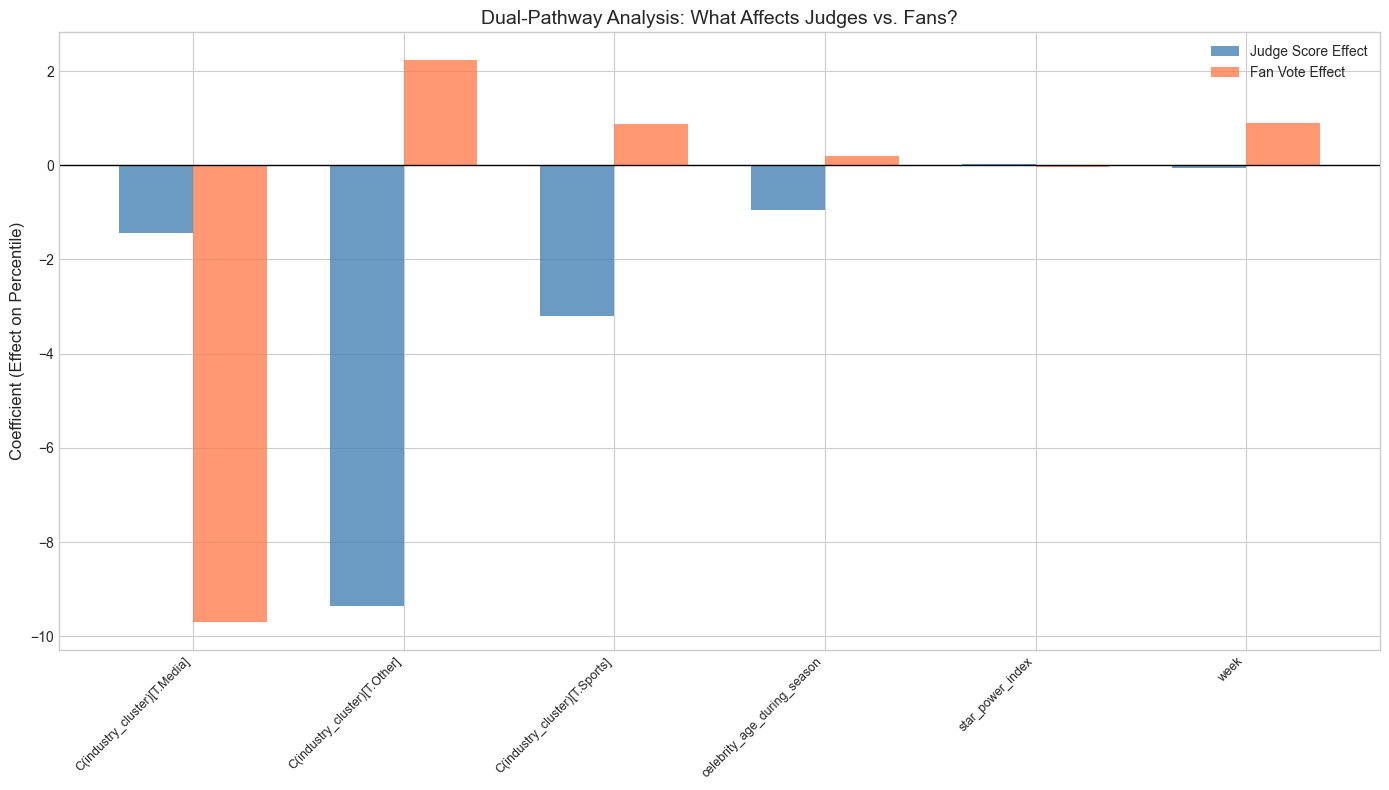

In [21]:
# Visualize dual-pathway comparison
fig, ax = plt.subplots(figsize=(14, 8))

# Filter to non-intercept variables
comp_plot = comparison[comparison['variable'] != 'Intercept'].copy()

x = np.arange(len(comp_plot))
width = 0.35

bars1 = ax.bar(x - width/2, comp_plot['judge_coef'], width, label='Judge Score Effect', 
               color='steelblue', alpha=0.8)
bars2 = ax.bar(x + width/2, comp_plot['fan_coef'], width, label='Fan Vote Effect',
               color='coral', alpha=0.8)

ax.axhline(0, color='black', linestyle='-', linewidth=1)
ax.set_xticks(x)
ax.set_xticklabels(comp_plot['variable'], rotation=45, ha='right', fontsize=9)
ax.set_ylabel('Coefficient (Effect on Percentile)', fontsize=12)
ax.set_title('Dual-Pathway Analysis: What Affects Judges vs. Fans?', fontsize=14)
ax.legend()

plt.tight_layout()
plt.savefig(OUTPUT_PATH / 'dual_pathway_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

---

## 6. Feature Importance via Random Forest

In [22]:
# Prepare data for Random Forest
rf_features = ['celebrity_age_during_season', 'star_power_index', 'industry_code',
               'region_code', 'pro_experience', 'win_rate', 'first_week_score']

X_rf = df[rf_features].fillna(0)
y_rf = df['placement']

# Fit Random Forest
rf_model = RandomForestRegressor(n_estimators=200, max_depth=10, random_state=42, n_jobs=-1)
rf_model.fit(X_rf, y_rf)

# Feature importance
importance_df = pd.DataFrame({
    'feature': rf_features,
    'importance': rf_model.feature_importances_
}).sort_values('importance', ascending=False)

print("\n📊 RANDOM FOREST FEATURE IMPORTANCE:")
print("="*50)
print(importance_df.to_string(index=False))


📊 RANDOM FOREST FEATURE IMPORTANCE:
                    feature  importance
           first_week_score    0.359270
celebrity_age_during_season    0.223531
             pro_experience    0.123909
           star_power_index    0.114695
                   win_rate    0.102242
                region_code    0.056912
              industry_code    0.019441


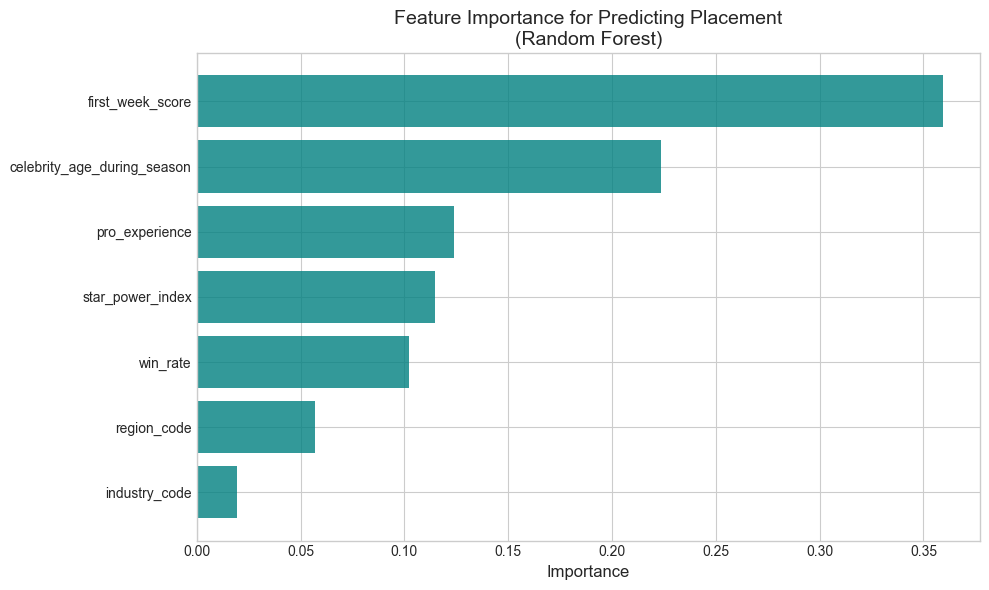

In [23]:
# Visualize feature importance
fig, ax = plt.subplots(figsize=(10, 6))

bars = ax.barh(importance_df['feature'], importance_df['importance'], 
               color='teal', alpha=0.8)
ax.set_xlabel('Importance', fontsize=12)
ax.set_title('Feature Importance for Predicting Placement\n(Random Forest)', fontsize=14)
ax.invert_yaxis()

plt.tight_layout()
plt.savefig(OUTPUT_PATH / 'feature_importance.png', dpi=150, bbox_inches='tight')
plt.show()

---

## 7. Summary

In [24]:
print("="*70)
print("OBJECTIVE 3: MIXED-EFFECTS & PROPENSITY SCORE ANALYSIS SUMMARY")
print("="*70)

print(f"""
📊 KEY FINDINGS:

1. PRO DANCER IMPACT:
   - ICC = {icc:.1%} → Pro dancer explains {icc:.1%} of placement variance
   - Top pros (by historical win rate): {pro_effects.head(3)['pro_dancer'].tolist()}
   - Propensity-matched ATE: {ate_placement:.2f} places (Top pro advantage)

2. CELEBRITY CHARACTERISTICS:
   - Star Power Index correlation with placement: {df['star_power_index'].corr(df['placement']):.3f}
   - Age effect on placement (mixed model): {fixed_effects[fixed_effects['variable'].str.contains('age')]['coefficient'].values[0]:.3f}

3. DUAL-PATHWAY (JUDGE vs FAN):
   - Judge model R²: {judge_model.rsquared:.3f}
   - Fan model R²: {fan_model.rsquared:.3f}
   - Key difference: {'Star Power affects fans MORE than judges' if comparison[comparison['variable']=='star_power_index']['diff'].values[0] < 0 else 'Star Power affects judges MORE than fans'}

4. FEATURE IMPORTANCE (Random Forest):
   - Top predictor: {importance_df.iloc[0]['feature']} ({importance_df.iloc[0]['importance']:.3f})
   - Pro-related features: win_rate ({importance_df[importance_df['feature']=='win_rate']['importance'].values[0]:.3f})

📁 FILES SAVED:
   - {OUTPUT_PATH / 'pro_dancer_effects.png'}
   - {OUTPUT_PATH / 'celebrity_effects.png'}
   - {OUTPUT_PATH / 'propensity_overlap.png'}
   - {OUTPUT_PATH / 'dual_pathway_comparison.png'}
   - {OUTPUT_PATH / 'feature_importance.png'}

➡️ NEXT: See 13_pro_dancer_impact_score.ipynb for PDIS development
""")

OBJECTIVE 3: MIXED-EFFECTS & PROPENSITY SCORE ANALYSIS SUMMARY

📊 KEY FINDINGS:

1. PRO DANCER IMPACT:
   - ICC = 5.3% → Pro dancer explains 5.3% of placement variance
   - Top pros (by historical win rate): ['Derek Hough', 'Kym Johnson', 'Cheryl Burke']
   - Propensity-matched ATE: -1.70 places (Top pro advantage)

2. CELEBRITY CHARACTERISTICS:
   - Star Power Index correlation with placement: 0.110
   - Age effect on placement (mixed model): 0.115

3. DUAL-PATHWAY (JUDGE vs FAN):
   - Judge model R²: 0.174
   - Fan model R²: 0.015
   - Key difference: Star Power affects judges MORE than fans

4. FEATURE IMPORTANCE (Random Forest):
   - Top predictor: first_week_score (0.359)
   - Pro-related features: win_rate (0.102)

📁 FILES SAVED:
   - ../../data/obj3/pro_dancer_effects.png
   - ../../data/obj3/celebrity_effects.png
   - ../../data/obj3/propensity_overlap.png
   - ../../data/obj3/dual_pathway_comparison.png
   - ../../data/obj3/feature_importance.png

➡️ NEXT: See 13_pro_dancer_im